In [7]:
import numpy as np
import pandas as pd
from eod import EodHistoricalData
import os
import requests
import pandas_market_calendars as mcal
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from talib import ATR
from scipy.stats import t
import yfinance as yf
from statsmodels.api import OLS, add_constant

In [8]:
api_key = os.environ.get('API_EOD')
client = EodHistoricalData(api_key)

In [3]:
np.random.seed(42)
url = "https://www.slickcharts.com/sp500"
headers = {'User-Agent': 'Mozilla/5.0'}

response = requests.get(url, headers=headers)
dfs = pd.read_html(response.text)
sp_tickers = list(dfs[0]['Symbol'].sample(10))

In [9]:
sp_tickers

['HSY', 'BLK', 'TSCO', 'AJG', 'FI', 'WTW', 'WRB', 'ANET', 'T', 'IR']

In [5]:
data = []
for ticker in sp_tickers:

    price = pd.DataFrame(client.get_prices_intraday(f'{ticker}.US', interval='1m'))
    price['symbol'] = np.full(fill_value=ticker, shape=(len(price),))
    data.append(price)

data = pd.concat(data, axis=0)

data['datetime'] = pd.to_datetime(data['datetime'])
data = data.drop(['timestamp', 'gmtoffset'], axis=1)

In [10]:
data

,datetime,open,high,low,close,volume,symbol
0,2023-09-25 08:03:00,209.0000,209.0000,209.0000,209.0000,3,HSY
1,2023-09-25 09:01:00,207.9400,207.9400,207.9400,207.9400,4,HSY
2,2023-09-25 10:32:00,207.3500,207.3500,207.3500,207.3500,2,HSY
3,2023-09-25 11:35:00,206.9000,208.0000,206.9000,208.0000,7,HSY
4,2023-09-25 12:00:00,207.9400,207.9400,207.9400,207.9400,2,HSY
...,...,...,...,...,...,...,...
32272,2024-01-19 21:17:00,78.8800,78.8800,78.8800,78.8800,6,IR
32273,2024-01-19 21:25:00,78.5291,78.5291,78.5291,78.5291,426,IR
32274,2024-01-19 22:27:00,78.5600,78.5600,78.5600,78.5600,2,IR
32275,2024-01-19 23:30:00,78.8800,78.8800,78.8800,78.8800,378863,IR


In [11]:
nyse = mcal.get_calendar('NYSE')
start_date = data['datetime'].min()
end_date = data['datetime'].max()
schedule = nyse.schedule(start_date=start_date, end_date=end_date)
data['date'] = data['datetime'].dt.date
open_mask = {}
close_mask = {}
for i in schedule.iterrows():
    open_mask[i[0]] = i[1][0]
    close_mask[i[0]] = i[1][1]
data = data[data['date'].isin(schedule.index.date)]
data['open_market'] = data['date'].map(open_mask)
data['close_market'] = data['date'].map(close_mask)
data = data[(data['datetime'].dt.time > data['open_market'].dt.time) & (data['datetime'].dt.time < data['close_market'].dt.time)]
data = data.set_index(['symbol', 'datetime'])[['open', 'high', 'low', 'close', 'volume']]

C:\Users\ftiag\AppData\Local\Temp\ipykernel_12092\1367626671.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['open_market'] = data['date'].map(open_mask)
C:\Users\ftiag\AppData\Local\Temp\ipykernel_12092\1367626671.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['close_market'] = data['date'].map(close_mask)


In [12]:
data

open     high      low    close  volume
symbol datetime                                                        
HSY    2023-09-25 13:31:00  206.8300  207.130  206.750  206.910    3604
       2023-09-25 13:32:00  207.0800  207.360  207.080  207.150    2695
       2023-09-25 13:33:00  207.0200  207.150  206.990  206.990    1000
       2023-09-25 13:35:00  207.2150  207.215  207.035  207.035    1343
       2023-09-25 13:36:00  207.2100  207.210  206.980  206.980    3534
...                              ...      ...      ...      ...     ...
IR     2024-01-19 20:55:00   78.8500   78.920   78.850   78.870   33015
       2024-01-19 20:56:00   78.8700   78.910   78.850   78.850   28528
       2024-01-19 20:57:00   78.8575   78.890   78.840   78.885   29843
       2024-01-19 20:58:00   78.8850   78.885   78.800   78.830   53865
       2024-01-19 20:59:00   78.8300   78.880   78.790   78.880  134067

[287352 rows x 5 columns]

In [13]:
def find_levels(
    log_price: np.array,
    atr: float,
    first_w: float = 0.1,
    atr_mult: float = 3.0,
    prom_thresh: float = 0.1): # 0 < prom_thresh < 1

    last_w = 1.0
    w_step = (last_w - first_w) / len(log_price)
    weights = first_w + np.arange(len(log_price)) * w_step
    weights[weights < 0] = 0.0

    kernal = gaussian_kde(log_price, bw_method=atr*atr_mult, weights=weights)

    min_v = np.min(log_price)
    max_v = np.max(log_price)
    step = (max_v - min_v) / 200
    log_price_range = np.arange(min_v, max_v, step)
    pdf = kernal(log_price_range)

    pdf_max = np.max(pdf)
    prom_min = pdf_max * prom_thresh

    peaks, props = find_peaks(pdf, prominence=prom_min)
    levels = []
    for peak in peaks:
        levels.append(np.exp(log_price_range[peak]))

    return levels, peaks, props, log_price_range, pdf, weights

In [34]:
log_data_test = data.loc['WRB'].iloc[-1000:].apply(np.log, axis=0)

In [35]:
atr = ATR(log_data_test['high'], log_data_test['low'], log_data_test['close'], 1000-1)[-1]

In [36]:
levels, peaks, props, log_price_range, pdf, weights = find_levels(log_data_test['close'], atr, atr_mult=100)

In [14]:
def support_resistance_levels(data, lookback, first_w=0.1, atr_mult=10, prom_thresh=0.25):

    atr = ATR(np.log(data['high']), np.log(data['low']), np.log(data['close']), lookback)

    all_levels = [None] * len(data)

    for i in range(lookback, len(data)):
        i_start = i - lookback
        vals = np.log(data.iloc[i_start+1: i+1]['close'])
        levels = find_levels(vals, atr.iloc[i], first_w, atr_mult, prom_thresh)[0]
        all_levels[i] = levels

    return all_levels

In [15]:
lookback = 500
sup_res_dict = {}

for ticker in sp_tickers:
    
    sup_res = support_resistance_levels(data.loc[ticker], lookback)

    sup_res_dict[ticker] = sup_res    

In [17]:
data['ma_25'] = data.groupby(level='symbol', group_keys=False, as_index=False).apply(lambda x: x.close.rolling(25).mean())
data['ma_50'] = data.groupby(level='symbol', group_keys=False, as_index=False).apply(lambda x: x.close.rolling(50).mean())

In [24]:
sup_res_list = []
for ticker in sp_tickers:
    sup_res = pd.DataFrame(sup_res_dict[ticker], columns=['support'])
    index = pd.DataFrame([data.loc[ticker].index, np.full(fill_value=ticker, shape=(len(data.loc[ticker]),))]).T
    index.columns = ['datetime', 'symbol']
    
    
    sup_res_list.append(pd.concat([sup_res, index], axis=1))

In [ ]:
sup_res_df = pd.concat(sup_res_list, axis=0).set_index(['symbol', 'datetime'])
data = data.join(sup_res_df)

In [26]:
data['forward_return'] = data.groupby(level='symbol', group_keys=False).apply(lambda x: x.close.pct_change().shift(-1))
data = data.dropna()

In [27]:
data

open    high      low    close  volume  \
symbol datetime                                                          
HSY    2023-09-26 15:42:00  204.2900  204.38  204.290  204.380     666   
       2023-09-26 15:43:00  204.4200  204.46  204.420  204.430    1519   
       2023-09-26 15:45:00  204.5100  204.51  204.505  204.505     511   
       2023-09-26 15:46:00  204.5100  204.57  204.490  204.490    1277   
       2023-09-26 15:47:00  204.4700  204.47  204.470  204.470     738   
...                              ...     ...      ...      ...     ...   
IR     2024-01-19 20:53:00   78.7600   78.77   78.730   78.770   17715   
       2024-01-19 20:54:00   78.7700   78.84   78.770   78.840   17859   
       2024-01-19 20:55:00   78.8500   78.92   78.850   78.870   33015   
       2024-01-19 20:56:00   78.8700   78.91   78.850   78.850   28528   
       2024-01-19 20:57:00   78.8575   78.89   78.840   78.885   29843   

                                 ma_25       ma_50  \
symbol datetime                                      
HSY    2023-09-26 15:42:00  204.596524  204.448494   
       2023-09-26 15:43:00  204.590524  204.454094   
       2023-09-26 15:45:00  204.585524  204.460494   
       2023-09-26 15:46:00  204.584724  204.467294   
       2023-09-26 15:47:00  204.575324  204.474694   
...                                ...         ...   
IR     2024-01-19 20:53:00   78.723000   78.752300   
       2024-01-19 20:54:00   78.727000   78.751900   
       2024-01-19 20:55:00   78.733000   78.752500   
       2024-01-19 20:56:00   78.738400   78.753000   
       2024-01-19 20:57:00   78.745200   78.752900   

                                                                      support  \
symbol datetime                                                                 
HSY    2023-09-26 15:42:00  [204.0943400766443, 204.17871502044474, 204.45...   
       2023-09-26 15:43:00  [204.0943400766443, 204.17871502044474, 204.43...   
       2023-09-26 15:45:00  [204.0943400766443, 204.17871502044474, 204.43...   
       2023-09-26 15:46:00  [204.0943400766443, 204.17871502044474, 204.43...   
       2023-09-26 15:47:00  [204.0943400766443, 204.17871502044474, 204.43...   
...                                                                       ...   
IR     2024-01-19 20:53:00  [78.0683897401486, 78.11948876517137, 78.17062...   
       2024-01-19 20:54:00  [78.0683897401486, 78.11948876517137, 78.17062...   
       2024-01-19 20:55:00  [78.0683897401486, 78.11948876517137, 78.17062...   
       2024-01-19 20:56:00  [78.0683897401486, 78.11948876517137, 78.17062...   
       2024-01-19 20:57:00  [78.0683897401486, 78.11948876517137, 78.17062...   

                            forward_return  
symbol datetime                             
HSY    2023-09-26 15:42:00        0.000245  
       2023-09-26 15:43:00        0.000367  
       2023-09-26 15:45:00       -0.000073  
       2023-09-26 15:46:00       -0.000098  
       2023-09-26 15:47:00        0.000196  
...                                    ...  
IR     2024-01-19 20:53:00        0.000889  
       2024-01-19 20:54:00        0.000381  
       2024-01-19 20:55:00       -0.000254  
       2024-01-19 20:56:00        0.000444  
       2024-01-19 20:57:00       -0.000697  

[282332 rows x 9 columns]

In [28]:
data_test_backtest = data.copy()

In [30]:
data_test_backtest['signal'] = np.sign(data['ma_25'] - data['ma_50'])
data_test_backtest['shifted_signal'] = data_test_backtest['signal'].groupby(level='symbol', group_keys=False).apply(lambda x: x.shift(1))
data_test_backtest['switch'] = data_test_backtest['shifted_signal'] != data_test_backtest['signal']

In [31]:
def find_nearest_support(x, alpha = 0.001, beta = 0.0001):

    if x.switch:
        
        if len(x.support) == 0:
            stop_loss = x.close + (x.close * alpha)
        
        elif x.signal == -1:
            relative_distance = x.close - np.array(x.support)

        else:
            relative_distance = np.array(x.support) - x.close
    
        only_neg = np.where(relative_distance > 0, -1000, 0)
        indice = np.argmax(only_neg)
        if x.signal == -1:
            stop_loss = x.support[indice] + x.support[indice] * beta
        else:
            stop_loss = x.support[indice] - x.support[indice] * beta
            
        return stop_loss

    else:
        return np.nan

stop_all_ticker = []

for ticker in sp_tickers:
    
    stop_for_ticker = data_test_backtest.loc[ticker].apply(find_nearest_support, axis=1).fillna(method='ffill').to_frame()
    stop_for_ticker['symbol'] = np.full(fill_value=ticker, shape=(len(stop_for_ticker),))
    stop_all_ticker.append(stop_for_ticker.reset_index())

data_test_backtest['stop_loss'] = pd.concat(stop_all_ticker, axis=0).set_index(['symbol', 'datetime'])

In [32]:
data_test_backtest['signal'][(data_test_backtest['signal'] == -1) & (data_test_backtest['high'] > data_test_backtest['stop_loss'])] = 0
data_test_backtest['signal'][(data_test_backtest['signal'] == 1) & (data_test_backtest['low'] < data_test_backtest['stop_loss'])] = 0
data_test_backtest['shifted_signal'] = data_test_backtest['signal'].groupby(level='symbol', group_keys=False).apply(lambda x: x.shift(1))
data_test_backtest['signal'][(data_test_backtest['shifted_signal'] == 0) & (data_test_backtest['switch'] == False)] = 0

C:\Users\ftiag\AppData\Local\Temp\ipykernel_12092\4086699599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_backtest['signal'][(data_test_backtest['signal'] == -1) & (data_test_backtest['high'] > data_test_backtest['stop_loss'])] = 0
C:\Users\ftiag\AppData\Local\Temp\ipykernel_12092\4086699599.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test_backtest['signal'][(data_test_backtest['signal'] == 1) & (data_test_backtest['low'] < data_test_backtest['stop_loss'])] = 0
C:\Users\ftiag\AppData\Local\Temp\ipykernel_12092\4086699599.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [117]:
broker_fees = 0.00001
bid_ask_spread = 0.0005
total_fees = broker_fees + bid_ask_spread

data_test_backtest['shifted_signal'] = data_test_backtest['signal'].groupby(level='symbol', group_keys=False).apply(lambda x: x.shift(1))

cond = ((data_test_backtest['signal'] == 1) & (data_test_backtest['shifted_signal'] == -1)) | ((data_test_backtest['signal'] == -1) & (data_test_backtest['shifted_signal'] == 1)) | ((data_test_backtest['signal'] != 0) & (data_test_backtest['shifted_signal'] == 0))

data_test_backtest['fees'] = cond * total_fees
data_test_backtest['backtest'] = data_test_backtest['signal'] * data_test_backtest['forward_return'] - data_test_backtest['fees']

In [118]:
backtest_returns = data_test_backtest['backtest'].groupby(level='symbol', group_keys=False).apply(lambda x: x.shift(1))

In [119]:
backtest_returns = backtest_returns.unstack(0).sort_index().dropna()

In [120]:
backtest_returns

symbol,AJG,ANET,BLK,FI,HSY,IR,T,TSCO,WRB,WTW
datetime,,,,,,,,,,
2023-09-26 18:24:00,0.000086,-0.000561,0.000340,9.321832e-05,-0.000000,0.000318,-0.000864,0.000442,0.000233,0.000187
2023-09-26 18:25:00,0.000194,-0.000225,0.000209,-1.306677e-04,0.000000,-0.000159,-0.000865,0.000564,0.000311,0.000234
2023-09-26 18:26:00,-0.000194,0.000449,-0.000379,-8.712319e-07,0.000000,-0.000159,0.000000,-0.000221,-0.000388,0.000515
2023-09-26 18:27:00,0.000086,-0.000449,-0.000394,-1.733753e-04,0.000000,-0.000159,0.000260,0.000884,0.000233,0.000234
2023-09-26 18:28:00,0.000972,-0.000225,-0.000046,8.713838e-05,-0.000000,0.000080,0.000073,-0.000049,-0.000155,0.000609
...,...,...,...,...,...,...,...,...,...,...
2024-01-19 20:53:00,0.000314,0.000266,0.000093,3.594149e-05,-0.000158,0.000000,0.000600,-0.000994,-0.000597,0.000400
2024-01-19 20:54:00,-0.000691,-0.000884,0.000000,2.156412e-04,-0.000525,0.000000,0.000300,-0.001209,0.000664,-0.001141
2024-01-19 20:55:00,0.000021,-0.000104,-0.000248,-5.030543e-04,0.000614,0.000000,0.000600,0.000604,0.000597,-0.001159


In [121]:
backtest_returns = np.cumprod(backtest_returns+1).resample('D', label='right').last().dropna().pct_change().dropna()

In [122]:
backtest_returns.index = backtest_returns.index - pd.Timedelta(days=1)

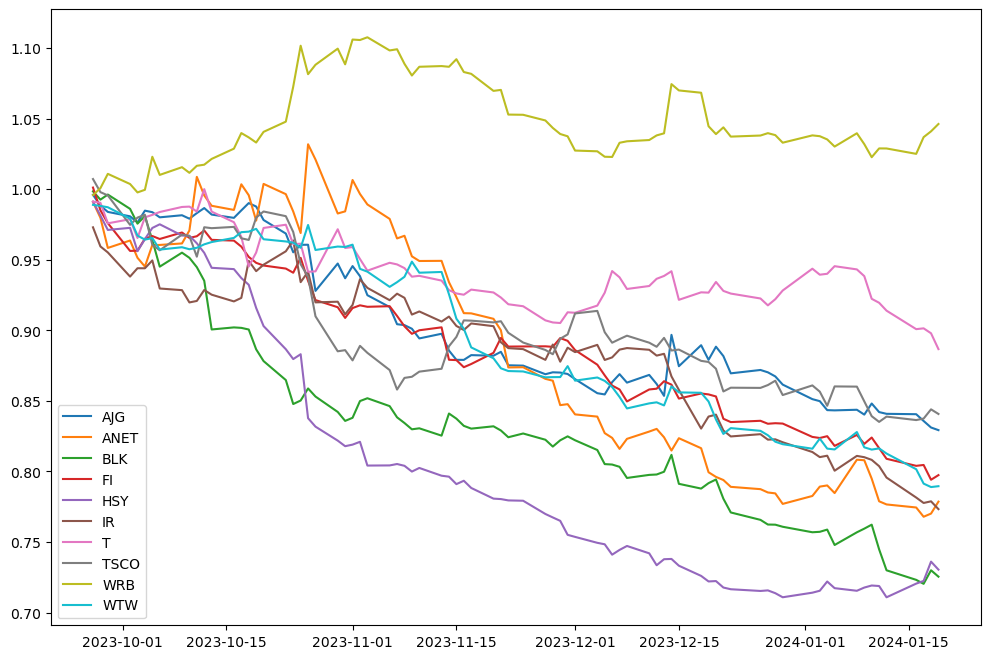

In [123]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumprod(backtest_returns+1), label=backtest_returns.columns)
plt.legend()
plt.show()

In [99]:
min_date = backtest_returns.index.min() - pd.DateOffset(months=1)
date_str = min_date.strftime('%Y-%m-%d')

In [100]:
sp_returns = yf.download("^GSPC", date_str)['Adj Close'].pct_change().dropna()

[*********************100%***********************]  1 of 1 completed


In [101]:
backtest_returns = backtest_returns.join(sp_returns).rename({'Adj Close': 'sp500'}, axis=1)

In [102]:
def t_stat_sharpe(backtest_returns, sharpe_target, r):

    stat_df = {}
    
    for ticker in sp_tickers:
        ticker_returns = backtest_returns[ticker]
        mu = ticker_returns.mean()
        sigma = ticker_returns.std()
        sharpe = (mu - r) / sigma
        sigma_sr = np.sqrt((1 + 0.5 * sharpe**2)/len(backtest_returns))
        t_statistic = (sharpe - sharpe_target)/sigma_sr
        p_value = (1 - t.cdf(np.abs(t_statistic), df=len(ticker_returns) - 2)) * 2
        stats = {'sharpe' : sharpe, 't-stat': t_statistic, 'p_value': p_value}
        stat_df[ticker] = stats
    return stat_df

$ e^{r252} = (1 + R) $ 

In [103]:
n_day = 252
r = 0.05
sharpe_target = 0
r_daily = np.log(1 + r) / (n_day)
sharpe_target_daily = sharpe_target / np.sqrt(n_day)

$ r_i - r_f = \alpha + \beta (r_m - r_f) + \varepsilon $

In [104]:
backtest_medaf = backtest_returns.copy() - r_daily

In [105]:
sp_tickers

['HSY', 'BLK', 'TSCO', 'AJG', 'FI', 'WTW', 'WRB', 'ANET', 'T', 'IR']

In [106]:
x = add_constant(backtest_medaf[['sp500']])
y = backtest_medaf[['WRB']]

model = OLS(endog=y, exog=x)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    WRB   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.5649
Date:                Sun, 21 Jan 2024   Prob (F-statistic):              0.455
Time:                        17:24:25   Log-Likelihood:                 252.71
No. Observations:                  79   AIC:                            -501.4
Df Residuals:                      77   BIC:                            -496.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.001     -1.961      0.053      -0.005    3.42e-05
sp500          0.1150      0.153      0.752      0.455      -0.190       0.420
==============================================================================
Omnibus:                       11.484   Durbin-Watson:                   2.188
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.835
Skew:                           0.613   Prob(JB):                     0.000364
Kurtosis:                       4.819   Cond. No.                         136.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [107]:
stats_sharpe = pd.DataFrame(t_stat_sharpe(backtest_returns, sharpe_target_daily, r_daily))

In [108]:
stats_sharpe.loc['sharpe', :] = stats_sharpe.loc['sharpe', :] * np.sqrt(252)

In [109]:
stats_sharpe

,HSY,BLK,TSCO,AJG,FI,WTW,WRB,ANET,T,IR
sharpe,-1.118719e+01,-10.328971,-6.863429,-7.561829,-1.058047e+01,-1.148824e+01,-3.318917,-6.119863,-6.340309,-8.434404
t-stat,-5.606237e+00,-5.253830,-3.674954,-4.012396,-5.358732e+00,-5.726121e+00,-1.838294,-3.305902,-3.416331,-4.420755
p_value,3.092187e-07,0.000001,0.000438,0.000138,8.454377e-07,1.888312e-07,0.069876,0.001440,0.001016,0.000032
